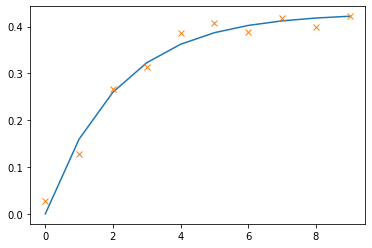

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import pyabc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import copy
import logging
import pickle
from study_abc_noise.model.conversion_reaction import *
%matplotlib inline

df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Acceptor')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Epsilon')
df_logger.setLevel(logging.DEBUG)

mv = ConversionReaction1dUVarModelVars()

def load_data():
    try:
        _data = pickle.load(open("data_cr.dat", "rb"))[1]
    except:
        _data_nonoise = mv.get_model()(mv.p_true)
        _data = mv.get_model_noisy()(mv.p_true)
        pickle.dump((_data_nonoise, _data), open("data_cr.dat", "wb"))
    return _data

data = load_data()
prior = mv.get_prior()
model = mv.get_model()
pop_size = 5000
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=20)

xmin = mv.limits['p0'][0]
xmax = mv.limits['p0'][1]

data_nonoise = model(mv.p_true)
plt.plot(data_nonoise['y'], '-')
plt.plot(data['y'], 'x')

## Analysis

In [ ]:
acceptor = pyabc.StochasticAcceptor()
temperature = pyabc.Temperature()
kernel = mv.get_kernel()

abc = pyabc.ABCSMC(model, prior, kernel, acceptor=acceptor,
                   eps=temperature, population_size=pop_size, sampler=sampler)
h = abc.new("sqlite:///h_cr_uvar.db", data)
h = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=1, start_time=2020-01-14 14:05:57.012707, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=2.5514e+01 for t=0.
DEBUG:Epsilon:Proposed temperatures for 0: [18.757450963791953].
INFO:ABC:t: 0, eps: 18.757450963791953.
DEBUG:Acceptor:Encountered pd=2.5517e+01 > c=2.5514e+01, thus weight=1.0001e+00.
DEBUG:Acceptor:Encountered pd=2.5523e+01 > c=2.5514e+01, thus weight=1.0005e+00.
INFO:ABC:Acceptance rate: 5000 / 16307 = 3.0662e-01, ESS=5.0000e+03.
DEBUG:Acceptor:pdf_norm=2.5523e+01 for t=1.
DEBUG:Epsilon:Proposed temperatures for 1: [5.279023889656522, 13.542849805450087].
INFO:ABC:t: 1, eps: 5.279023889656522.
DEBUG:Acceptor:Encountered pd=2.5526e+01 > c=2.5523e+01, thus weight=1.0006e+00.
DEBUG:Acceptor:Encountered pd=2.5531e+01 > c=2.5523e+01, thus weight=1.0016e+00.
DEBUG:Acceptor:Encountered pd=2.5525e+01 > c=2.5523e+01, thus weight=1.0003e+00.
DEBUG:Acceptor:Encountered pd=2.5524e+01 > c=2.5523e+01, thus weight=1.0002e+00.
D

In [ ]:
model_noisy = mv.get_model_noisy()
distance = mv.get_distance()

abc = pyabc.ABCSMC(model_noisy, prior, distance,
                   population_size=pop_size, sampler=sampler)
h = abc.new("sqlite:///h_cr_uvar_noisymodel.db", data)
h = abc.run(min_acceptance_rate=1e-3)

DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1
INFO:History:Start <ABCSMC(id=1, start_time=2020-01-14 14:09:23.177396, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 232.04418870220715
INFO:ABC:t: 0, eps: 232.04418870220715.
INFO:ABC:Acceptance rate: 5000 / 10096 = 4.9525e-01, ESS=5.0000e+03.
DEBUG:Epsilon:new eps, t=1, eps=82.67511501893986
INFO:ABC:t: 1, eps: 82.67511501893986.
INFO:ABC:Acceptance rate: 5000 / 10178 = 4.9126e-01, ESS=4.7944e+03.
DEBUG:Epsilon:new eps, t=2, eps=41.81466468731342
INFO:ABC:t: 2, eps: 41.81466468731342.
INFO:ABC:Acceptance rate: 5000 / 10701 = 4.6725e-01, ESS=4.6089e+03.
DEBUG:Epsilon:new eps, t=3, eps=26.420258836860526
INFO:ABC:t: 3, eps: 26.420258836860526.
INFO:ABC:Acceptance rate: 5000 / 12358 = 4.0460e-01, ESS=3.7635e+03.
DEBUG:Epsilon:new eps, t=4, eps=18.980850996105882
INFO:ABC:t: 4, eps: 18.980850996105882.
INFO:ABC:Acceptance rate: 5000 / 13921 = 3.5917e-01, ESS=1

## Plots

### Plot final

In [2]:
def normal_dty_1d(y_obs, y, sigma):
    dty = ( 1 / np.sqrt(2 * np.pi * sigma**2)
            * np.exp(-((y_obs - y) / sigma)**2 / 2) )
    return dty

def normal_dty(y_obs, y, sigma):
    dim = len(y_obs)
    dties = np.zeros(dim)
    for j in range(dim):
        dties[j] = normal_dty_1d(y_obs[j], y[j], sigma[j])
    dty= np.prod(dties)
    return dty

uniform_pd = 1 / ((mv.limits['p0'][1] - mv.limits['p0'][0])
                  * (mv.limits['std'][1] - mv.limits['std'][0]))

def posterior_unscaled(p):
    if type(p) is not dict:
        p = {key: p[i] for i, key in enumerate(mv.p_true)}

    y = model(p)['y'].flatten()
    sigma = p['std'] * np.ones(mv.n_t)
    
    # likelihood
    likelihood_val = normal_dty(data['y'], y, sigma)
    
    # prior
    prior_val = prior.pdf(p)
    
    return likelihood_val * prior_val

def get_posterior_scaled():
    total = sp.integrate.dblquad(
        lambda std, p0: posterior_unscaled([p0, std]),
        mv.limits['p0'][0], mv.limits['p0'][1],
        lambda std: mv.limits['std'][0],
        lambda std: mv.limits['std'][1],
    )
    print("total: ", total)
    return lambda p: posterior_unscaled(p) / total[0]

posterior = get_posterior_scaled()

def marg_p0(p0):
    return sp.integrate.quad(
        lambda std: posterior([p0, std]),
            mv.limits['std'][0], mv.limits['std'][1])[0]

def marg_std(std):
    return sp.integrate.quad(
        lambda p0: posterior([p0, std]),
            mv.limits['p0'][0], mv.limits['p0'][1])[0]

p0s = np.linspace(mv.limits['p0'][0], mv.limits['p0'][1], 100)
vals_p0 = [marg_p0(p0) for p0 in p0s]

stds = np.linspace(mv.limits['std'][0], mv.limits['std'][1], 100)
vals_std = [marg_std(std) for std in stds]

total:  (1918764780.5172927, 8.939569708425552)


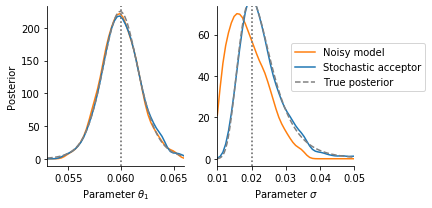

In [3]:
h = pyabc.History("sqlite:///h_cr_uvar.db")
h_noisymodel = pyabc.History("sqlite:///h_cr_uvar_noisymodel.db")

fig, arr_ax = plt.subplots(1, 2)

for ip, p in enumerate(['p0', 'std']):
    pyabc.visualization.plot_kde_1d_highlevel(
        h_noisymodel, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1],
        refval = mv.p_true, ax=arr_ax[ip], color='C1', label=None if ip==0 else "Noisy model",
        refval_color='grey')
    pyabc.visualization.plot_kde_1d_highlevel(
        h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1],
        refval = mv.p_true, ax=arr_ax[ip], color='C0', label=None if ip==0 else "Stochastic acceptor",
        refval_color='grey')

arr_ax[0].plot(p0s, vals_p0, '--', color='grey')
arr_ax[1].plot(stds, vals_std, '--', label="True posterior", color='grey')

arr_ax[1].legend(loc='upper left', bbox_to_anchor=(0.5, 0.8))

arr_ax[0].set_xlabel("Parameter $\\theta_1$")
arr_ax[1].set_xlabel("Parameter $\\sigma$")
arr_ax[1].set_ylabel(None)

for ax in arr_ax:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.set_size_inches((6, 3))
fig.tight_layout()
for fmt in ['svg', 'eps']:
    plt.savefig(f"cr_uvar_with_true.{fmt}", format=fmt)

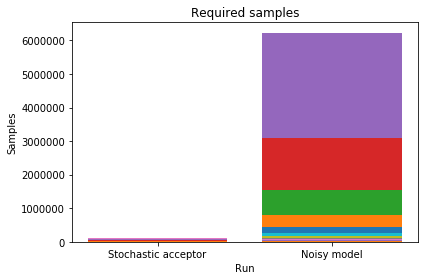

In [4]:
pyabc.visualization.plot_sample_numbers([h, h_noisymodel], ["Stochastic acceptor", "Noisy model"])

In [13]:
# get the numbers
print("Total samples stochastic acceptor: ", sum(h.get_all_populations()['samples']))
print("Total samples noisy model: ", sum(h_noisymodel.get_all_populations()['samples']))

Total samples stochastic acceptor:  102759
Total samples noisy model:  6227123


### Plot all times

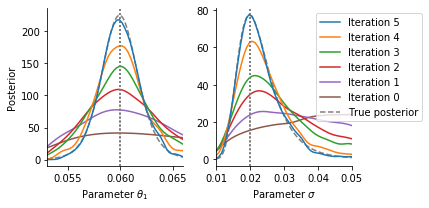

In [5]:
fig, arr_ax = plt.subplots(1, 2)

arr_ax[0].plot(p0s, vals_p0, '--', color='grey')
arr_ax[1].plot(stds, vals_std, '--', label="True posterior", color='grey')

for ip, p in enumerate(['p0', 'std']):
    for t in range(0, h.max_t+1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, t=t, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1],
            refval = mv.p_true, ax=arr_ax[ip], color=f'C{h.max_t-t}', label=f"Iteration {t}",
            refval_color='grey')

for ax in arr_ax:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
handles, labels = arr_ax[1].get_legend_handles_labels()
arr_ax[1].legend(handles[::-1], labels[::-1], loc="upper left", bbox_to_anchor=(0.7, 1))

arr_ax[0].set_xlabel("Parameter $\\theta_1$")
arr_ax[1].set_xlabel("Parameter $\\sigma$")
arr_ax[1].set_ylabel(None)

fig.set_size_inches((6,3))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f"cr_iterations.{fmt}", format=fmt)